# Import libraries

In [101]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import collections
import re
import string
import matplotlib.pyplot as plt
from collections import defaultdict
from bs4 import BeautifulSoup

from gensim import models
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import initializers
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Layer, InputSpec, TextVectorization
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding, MaxPooling1D,GRU, Bidirectional
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras import Sequential
from keras.utils.vis_utils import plot_model
from __future__ import division, print_function

os.environ['KERAS_BACKEND']='theano'
plt.switch_backend('agg')
%matplotlib inline

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

nltk and gensim are two famous libraries that are used in Natural Language Processing (NLP). nltk library has been used to get the stop words of English language and to lemmatize words. Also gensim library has been used to load the Doc2vec model

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
proj_dir='/content/drive/MyDrive/Colab Notebooks/doc2vec/' #give your project directory here. data sets should be in this location

# Load and clean the data

before converting into vectors text should be cleaned.

* Lower the english latters
* Remove headers
* Drop all digits
* Remove URLs and Emails
* Drop all punctuation from our text
* Drop stop words
* Lemmatize words


first, we convert all the letters into lowercase letters in order to avoid duplicating the same word ('Dog' and 'dog' are the same words. but the program will take these as two words. Hence we convert 'Dog' as 'dog' by doing letters lowercase)

After that we drop all the headers and numbers.Because headers are unwanted data and numbers don't have any meaning when we take them as a single word.

if any word contains '@','.com' or 'http' we drop those words. also we remove all punctuations and stop words. The words which are generally filtered out before processing a natural language are called stop words. These are actually the most common words such as “the”, “a”, “an”, “so”, “what” in English language. By removing these words, we remove the low-level information from our text in order to give more focus to the important information.

finally we lemmatize words. Lemmatization is the process wherein the context is used to convert a word to its meaningful base or root form. ex:- driving--> drive , dogs-->dog. To perform Lemmatization with Natural Language Tool Kit (NLTK), “WordNetLemmatizer()” method has been used

In [36]:
'''this function is used to read text files.'''
def read_txt_file(file_name):
    with open(file_name,encoding="utf8", errors='ignore') as f:
        ###extract the boady of the text###
        line = f.readline()
        txt=''
        txt=txt+' '+line
        while line:
            line = f.readline()
            txt=txt+' '+line
        ###################################
    f.close()
    return(txt)

In [37]:
stop_words=set(stopwords.words('english'))#load stop words
punctuations=string.punctuation #get punctuations
lemmatizer = WordNetLemmatizer()
'''this function is used to clean text'''
def clean_txt(txt):
    txt=txt.lower() #set all characters to lowercase
    sentences=txt.split('\n')
    txt = ' '.join([i for i in sentences if not ':' in i])#remove headers
    txt = ''.join([i for i in txt if not i.isdigit()])#remove numbers

    ###remove urls and emails###
    words=txt.split()
    txt = ' '.join([i for i in words if not '@' in i and not '.com' in i and not  'http:' in i])
    #######################################

    ###remove punctuations###
    for character in punctuations:
        txt = txt.replace(character, '')
    #########################################
    
    ###remove stop words and lemmatize###
    words=txt.split()
    filtered_txt = ' '.join([lemmatizer.lemmatize(i) for i in words if not i in stop_words])
    #####################################
    
    return(filtered_txt)

In [38]:
def load_and_clean_data(location):    
    y=os.listdir(location)#get the list of folder
    txts=[]
    txts_cleaned=[]
    folder_array=[]
    file_array=[]
    for i in range(len(y)):
        text_file_names=os.listdir(location+'/'+y[i]) #get the list of files
        for text_file_name in text_file_names:
                file_array.append(text_file_name)
                txt=read_txt_file(location+'/'+y[i]+'/'+text_file_name) #read the text file
                txts.append(txt)
                txts_cleaned.append(clean_txt(txt)) #clean the text
                folder_array.append(y[i])

    ###create a data frame###
    df=pd.DataFrame()
    df['texts']=txts
    df['text cleaned']=txts_cleaned
    df['folder name']=folder_array
    df['file name']=file_array
    ########################
    return (df)



In [39]:
df_train=load_and_clean_data(proj_dir+'20news-bydate-train')
df_test=load_and_clean_data(proj_dir+'20news-bydate-test')

In [40]:
df_train.head()

,texts,text cleaned,folder name,file name
0,Subject: MIT R5 on Sun with Rasterops TC Colo...,possible run mit r based xserver sun rasterops...,comp.windows.x,66939
1,Subject: Automated X testing\n From: mark@tri...,anyone know available term automated testing x...,comp.windows.x,67117
2,Subject: Re: Trouble compiling X11R5 on SunOS...,ive trying compile xr patchlevel sun sparc ipx...,comp.windows.x,66947
3,"Organization: Ministry of Education, Computer...",hp workstation us pseudocolor id x color defau...,comp.windows.x,67279
4,To: gnu-gdb-bug@gatech.edu\n Distribution: wo...,hi trying write xwindows based interface run t...,comp.windows.x,67410


In [41]:
df_test.head()

,texts,text cleaned,folder name,file name
0,Organization: University of Central Florida -...,hello considering buying hummingbird xwindows ...,comp.windows.x,67551
1,Organization: Queen's University at Kingston\...,tn program support xterm dont like x cant copy...,comp.windows.x,67566
2,Subject: Re: X on DOS or Windows\n From: clee...,im posting request since last one title im loo...,comp.windows.x,68196
3,From: iop@server2.iie.ncku.edu.tw\n Subject: ...,studying book unix desktop guide open look exa...,comp.windows.x,68332.eml
4,Subject: Re: Resource/Widget toolkit required...,anyone know public domain toolkits creating xw...,comp.windows.x,67972


In [42]:
#save clean data sets before vectorize it 
df_train.to_csv(proj_dir+'cleaned_train_data.csv')
df_test.to_csv(proj_dir+'cleaned_test_data.csv')

# Convert to vectors using doc2vec

---



document is tokenized into words and applied doc2vec model. doc2vec is a method to represent list of words using a vector. it is used to create a vectorised representation of a group of words taken collectively as a single unit.In gensim the model will always be trained on a word per word basis. Therefore  we split the document into an array of words using split(). In order to train the model, tagged documents are needed. it can be created by using models.doc2vec.TaggedDcument(). then finally we train the doc2vec model

In [43]:
'''this function is used to do tokenization'''
def tokenizer(txt):  
    tokens=txt.split(' ')
    unique_tokens=np.unique(np.array(tokens)) #get unique tokens
    ###create a dictonary of tokens###
    tokens_dict={}
    for indx in range(len(unique_tokens)):
        tokens_dict[unique_tokens[indx]]=indx
    return(tokens_dict,tokens)

In [44]:
#tokanize train and test data
words_list=[]
for i in range(len(df_train)):
    _,words=tokenizer(df_train['text cleaned'][i]) 
    words_list.append(words)
for i in range(len(df_test)):
    _,words=tokenizer(df_test['text cleaned'][i])
    words_list.append(words)
####################################

In [45]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(words_list)]
model = Doc2Vec(vector_size=200, min_count=2, epochs=30) #fit the Doc2Vec model
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

In [46]:
###get train vectors##
train_vectors=[]
for i in range(len(df_train)):
    train_vectors.append(model.infer_vector(list(df_train['text cleaned'][i].split(' '))))
##########################

In [47]:
##get test vectors##
test_vectors=[]
for i in range(len(df_test)):
    test_vectors.append(model.infer_vector(list(df_test['text cleaned'][i].split(' '))))
############################

In [48]:
train=pd.DataFrame(train_vectors)
train['folder name']=df_train['folder name']
train['file name']=df_train['file name']
test=pd.DataFrame(test_vectors)
test['folder name']=df_test['folder name']
test['file name']=df_test['file name']

In [49]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,folder name,file name
0,0.310415,0.136704,-0.087216,0.298513,0.442637,0.353522,-0.597703,0.283410,-0.448212,0.113848,...,-0.708581,-0.038234,0.172184,-0.034185,-0.242064,-0.179403,1.126774,0.204595,comp.windows.x,66939
1,-0.193481,0.085978,-0.497036,0.201905,0.299502,0.047104,-0.071296,0.693747,-0.673453,-0.458994,...,-0.439250,-0.106788,0.256676,0.305228,0.440451,-0.280097,0.714188,0.136678,comp.windows.x,67117
2,0.099069,-0.238318,0.281372,0.015878,0.391800,0.086147,0.308608,-0.013949,0.117587,0.327742,...,-0.296166,-0.145764,-0.073079,-0.283908,-0.403037,0.182654,0.325659,0.172531,comp.windows.x,66947
3,-0.125993,0.036401,0.159742,-0.161521,0.325371,-0.000287,0.248822,0.021615,-0.196689,0.183708,...,-0.210138,-0.078775,0.258939,-0.062659,-0.146810,-0.272262,0.078243,0.087233,comp.windows.x,67279
4,-0.329687,0.997195,-0.199240,-0.318719,1.583575,0.618358,-0.233754,0.167802,-0.210573,0.312986,...,-0.161861,0.286848,-0.183360,0.557465,0.410680,-0.353687,-0.016944,-0.590691,comp.windows.x,67410


In [50]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,folder name,file name
0,0.133185,0.423469,0.081548,0.090596,-0.254675,0.000366,0.024420,-0.096822,-0.180032,0.678559,...,-0.214092,0.087260,-0.411303,-0.452654,-0.150381,0.231505,0.402855,0.172514,comp.windows.x,67551
1,-0.184632,-0.043455,-0.161385,0.116354,-0.031490,0.364996,0.307403,0.185587,-0.263566,0.026891,...,-0.056884,0.169573,-0.040992,-0.054498,-0.268846,0.166100,0.390044,-0.374553,comp.windows.x,67566
2,-0.376402,0.065578,-0.087037,-0.167662,0.497388,0.270870,0.652337,0.031265,-0.563886,0.376378,...,0.017627,0.507739,-0.132540,-0.157758,0.131885,0.275516,0.361270,-0.045587,comp.windows.x,68196
3,0.299460,-0.392302,0.970576,-0.269815,2.194335,1.436635,-0.864641,2.998849,-0.030824,3.245740,...,-0.853212,1.352840,-1.432181,-1.088426,-0.294426,-0.214843,-0.167595,-1.108512,comp.windows.x,68332.eml
4,0.269204,0.352841,0.125711,-0.322222,-0.227007,0.068951,0.379783,0.393163,-0.746183,0.022370,...,-0.010730,0.205741,0.245451,-0.087486,0.519971,0.233960,-0.222063,-0.066223,comp.windows.x,67972


In [51]:
train_,validation=train_test_split( train, test_size=0.33, random_state=42) #split data into train and validation sets

In [52]:
len(train_),len(test),len(validation)

(7580, 7537, 3734)

In [53]:
#save data sets
train_.to_csv(proj_dir+'train_data.csv')
test.to_csv(proj_dir+'test_data.csv')
validation.to_csv(proj_dir+'validation_data.csv')

# Modeling

## Load data

In [104]:
#read data which was saved in the feature generation part
train=pd.read_csv(proj_dir+'train_data.csv')
test=pd.read_csv(proj_dir+'test_data.csv')
validation=pd.read_csv(proj_dir+'validation_data.csv')

## Data rearrange for modeling

In [105]:
#extract X and y data from data frames
X_train=train[[str(i) for i in range(40)]]
y_train=train['folder name']

X_test=test[[str(i) for i in range(40)]]
y_test=test['folder name']

X_validation=validation[[str(i) for i in range(40)]]
y_validation=validation['folder name']

In [106]:
names=np.unique(np.array(y_train)) #getting unique categories
print(names)

['alt.atheism' 'comp.graphics' 'comp.os.ms-windows.misc'
 'comp.sys.ibm.pc.hardware' 'comp.sys.mac.hardware' 'comp.windows.x'
 'misc.forsale' 'rec.autos' 'rec.motorcycles' 'rec.sport.baseball'
 'rec.sport.hockey' 'sci.crypt' 'sci.electronics' 'sci.med' 'sci.space'
 'soc.religion.christian' 'talk.politics.guns' 'talk.politics.mideast'
 'talk.politics.misc' 'talk.religion.misc']


In [107]:
# Category mapping
y_train_en=[np.where(names==name)[0] for name in y_train ]
y_test_en=[np.where(names==name)[0] for name in y_test ]
y_validation_en=[np.where(names==name)[0] for name in y_validation ]

In [108]:
# Category encoding
# keras.utils.to_categorical is a function used to Converts a class vector (integers) to binary class matrix
# so by the end of this code block we will have encoded categories so we are ready to use it in the model. 
y_train_en=keras.utils.to_categorical(y_train_en)
y_test_en=keras.utils.to_categorical(y_test_en)
y_validation_en=keras.utils.to_categorical(y_validation_en)

## Model

In [109]:
### building the model
classifier = Sequential() #The sequential API allows you to create models layer-by-layer for most problems.
classifier.add(Dense(units=100, input_dim=40, kernel_initializer='uniform', activation='relu'))# relu (Rectifier linear unit) function
classifier.add(Dense(units=80, kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(0.2)) # dropout layer to prevent overfitting
classifier.add(Dense(units=60, kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(0.2)) # dropout layer to prevent overfitting
classifier.add(Dense(units=30, kernel_initializer='uniform', activation='relu'))

####################### Output layer############################################
# sigmoid means sigmoid activation function
# for Multiclass classification the activation ='softmax'
classifier.add(Dense(units=20, kernel_initializer='uniform', activation='sigmoid'))
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 100)               4100      
                                                                 
 dense_6 (Dense)             (None, 80)                8080      
                                                                 
 dropout_2 (Dropout)         (None, 80)                0         
                                                                 
 dense_7 (Dense)             (None, 60)                4860      
                                                                 
 dropout_3 (Dropout)         (None, 60)                0         
                                                                 
 dense_8 (Dense)             (None, 30)                1830      
                                                                 
 dense_9 (Dense)             (None, 20)               

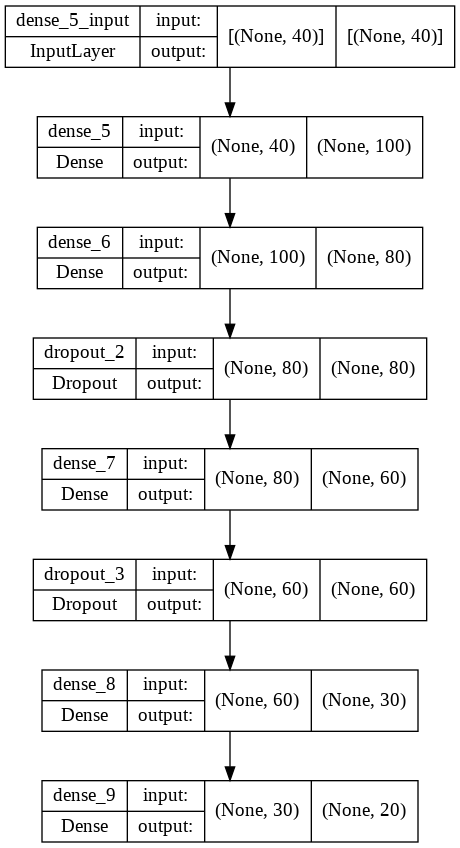

In [110]:
plot_model(classifier, to_file=proj_dir+'model_plot.png', show_shapes=True, show_layer_names=True) # plot and save the model diagramm

In [111]:
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #compile the model

# fitting the Neural Network on the training data
history=classifier.fit(X_train,y_train_en,validation_data=(X_validation, y_validation_en), batch_size=50 , epochs=40, verbose=1)

Epoch 1/40
152/152 [==============================] - 2s 6ms/step - loss: 0.3173 - accuracy: 0.0551 - val_loss: 0.2044 - val_accuracy: 0.0517
Epoch 2/40
152/152 [==============================] - 1s 4ms/step - loss: 0.2027 - accuracy: 0.0499 - val_loss: 0.1994 - val_accuracy: 0.0546
Epoch 3/40
152/152 [==============================] - 1s 4ms/step - loss: 0.2008 - accuracy: 0.0507 - val_loss: 0.1990 - val_accuracy: 0.0530
Epoch 4/40
152/152 [==============================] - 1s 4ms/step - loss: 0.2008 - accuracy: 0.0466 - val_loss: 0.1990 - val_accuracy: 0.0538
Epoch 5/40
152/152 [==============================] - 1s 4ms/step - loss: 0.2005 - accuracy: 0.0509 - val_loss: 0.1988 - val_accuracy: 0.0471
Epoch 6/40
152/152 [==============================] - 1s 4ms/step - loss: 0.2004 - accuracy: 0.0530 - val_loss: 0.1992 - val_accuracy: 0.0522
Epoch 7/40
152/152 [==============================] - 1s 4ms/step - loss: 0.2004 - accuracy: 0.0520 - val_loss: 0.1988 - val_accuracy: 0.0501
Epoch 

### Evaluate

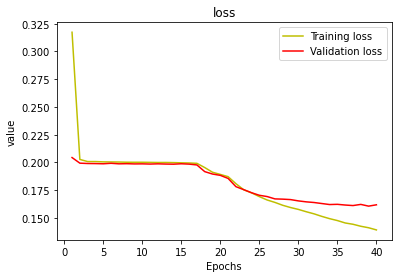

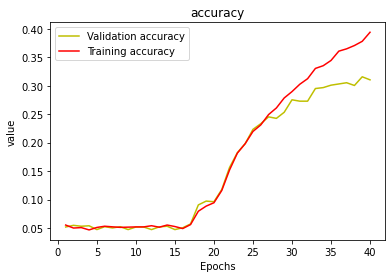

In [112]:
#plotting trainning, validation accuracies and losses
loss = history.history['loss']
loss_val = history.history['val_loss']
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, loss_val, 'r', label='Validation loss')
plt.title('loss')
plt.xlabel('Epochs')
plt.ylabel('value')
plt.legend()
plt.show()

plt.plot(epochs, acc_val, 'y', label='Validation accuracy')
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.title('accuracy')
plt.xlabel('Epochs')
plt.ylabel('value')
plt.legend()
plt.show()

In [113]:
#calculate the test accuracy
y_pred=np.argmax(classifier.predict(X_test),axis=1) #predict on test data
y_true=np.argmax(y_test_en,axis=1) #true values
acc=sum(y_pred==y_true)/len(y_pred) #calculate the accuracy
print('test accuracy : ',acc)

test accuracy :  0.28512670823935254


## Naive Bayes

In [114]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, PredefinedSplit

In [115]:
# combine validation and training sets to do grid search
X_train_val = pd.concat([X_train, X_validation], axis = 0)
X_train_val = X_train_val.reset_index(drop = True)

# y_train_val = pd.concat([y_train, y_validation], axis = 0)
# y_train_val = y_train_val.reset_index(drop = True)

In [116]:
y_train_val = np.concatenate((y_train_en, y_validation_en))
y_train_val  = pd.DataFrame(y_train_val).apply(lambda x: x.argmax(), axis=1).values
y_train_val

array([ 3,  4,  8, ..., 18, 17,  9])

In [117]:
y_test = pd.DataFrame(y_test_en).apply(lambda x: x.argmax(), axis=1).values

#### grid search 

In [118]:
# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1] * len(X_train) + [0] * len(X_validation)
pds = PredefinedSplit(test_fold = split_index)

gnb_clf = GaussianNB()
parameters = {
    'var_smoothing': [1e-1,1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
}
clf = GridSearchCV(gnb_clf, parameters, cv=pds, verbose=1, n_jobs=1) #it is hold-out validation here
clf.fit(X_train_val, y_train_val)

print('Best parameter:',clf.best_params_) #best performance on training set and its parameter
print('Best train accuracy score:', clf.best_score_)

Fitting 1 folds for each of 15 candidates, totalling 15 fits
Best parameter: {'var_smoothing': 0.1}
Best train accuracy score: 0.22897696839850026


In [119]:
#grid search performance
pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

,var_smoothing,Accuracy
0,1.000000e-01,0.228977
1,1.000000e-02,0.223889
2,1.000000e-03,0.223353
3,1.000000e-04,0.223621
4,1.000000e-05,0.223621
5,1.000000e-06,0.223621
6,1.000000e-07,0.223621
7,1.000000e-08,0.223621
8,1.000000e-09,0.223621
9,1.000000e-10,0.223621


In [120]:
#performance on test set
nb_pred = clf.best_estimator_.predict(X_test)
print('Test accuracy score:', accuracy_score(y_test, nb_pred))

macro_averaged_precision = precision_score(y_test, nb_pred, average = 'macro')
print('Test macro averaged precision score:', macro_averaged_precision)

recall = recall_score(y_test, nb_pred, average = 'macro')
print('Test recall score:', recall)

macro_averaged_f1 = f1_score(y_test, nb_pred, average = 'macro')
print('Test macro averaged f1 score:', macro_averaged_f1)

Test accuracy score: 0.21732784927690063
Test macro averaged precision score: 0.29447495240830623
Test recall score: 0.21169735867271347
Test macro averaged f1 score: 0.21171892107022341


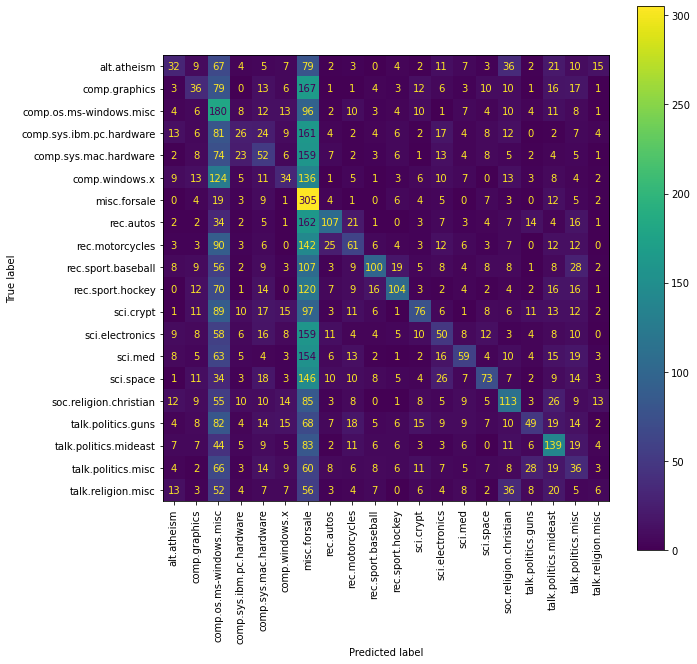

In [121]:
cm = confusion_matrix(y_test, nb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=names)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax)

plt.show()

## KNN

In [122]:
from sklearn.neighbors import KNeighborsClassifier

#### grid search

In [123]:
k_range = list(range(1, 31)) # possible k

param_grid = dict(n_neighbors=k_range)

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, param_grid, cv=pds, verbose=1, n_jobs=1)
  
# fitting the model for grid search
clf =clf.fit(X_train_val, y_train_val)
print('Best parameter:',clf.best_params_) #best performance on training set and its parameter
print('Best train accuracy score:', clf.best_score_)

Fitting 1 folds for each of 30 candidates, totalling 30 fits
Best parameter: {'n_neighbors': 1}
Best train accuracy score: 0.2656668452062132


In [124]:
#grid search performance
pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

,n_neighbors,Accuracy
0,1,0.265667
1,2,0.211302
2,3,0.207017
3,4,0.212908
4,5,0.215319
5,6,0.229513
6,7,0.238886
7,8,0.243171
8,9,0.240761
9,10,0.238350


In [125]:
#performance on test set
knn_pred = clf.best_estimator_.predict(X_test)
print('Test accuracy score:', accuracy_score(y_test, knn_pred))

macro_averaged_precision = precision_score(y_test, knn_pred, average = 'macro')
print('Test macro averaged precision score:', macro_averaged_precision)

recall = recall_score(y_test, knn_pred, average = 'macro')
print('Test recall score:', recall)

macro_averaged_f1 = f1_score(y_test, knn_pred, average = 'macro')
print('Test macro averaged f1 score:', macro_averaged_f1)

Test accuracy score: 0.1861483348812525
Test macro averaged precision score: 0.18910906461437807
Test recall score: 0.18416296247899513
Test macro averaged f1 score: 0.1849721400206965


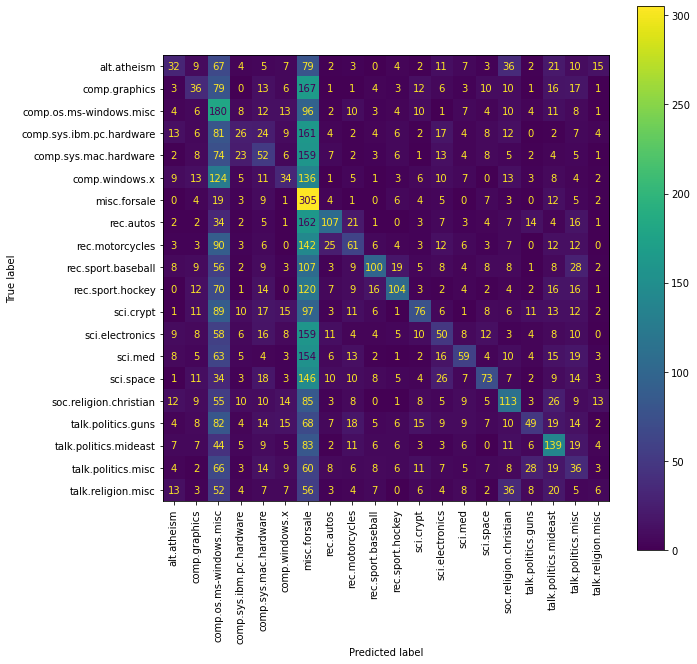

In [126]:
cm = confusion_matrix(y_test, nb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=names)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax)

plt.show()

## 1 dimensional CNN | Conv1D-without using Pre-trained Embedding

In [127]:
#define X and y
X = df_train['texts']
y = df_train['folder name']
X_test=df_test['texts']
y_test=df_test['folder name']

X_train, X_val = train_test_split(X, test_size=0.33, random_state=42) #use the same split seed as that used in knn and nb
y_train, y_val = train_test_split(y, test_size=0.33, random_state=42)

In [128]:
names=np.unique(np.array(y_train)) #getting unique categories
print(names)

['alt.atheism' 'comp.graphics' 'comp.os.ms-windows.misc'
 'comp.sys.ibm.pc.hardware' 'comp.sys.mac.hardware' 'comp.windows.x'
 'misc.forsale' 'rec.autos' 'rec.motorcycles' 'rec.sport.baseball'
 'rec.sport.hockey' 'sci.crypt' 'sci.electronics' 'sci.med' 'sci.space'
 'soc.religion.christian' 'talk.politics.guns' 'talk.politics.mideast'
 'talk.politics.misc' 'talk.religion.misc']


#### Creat Text Vectorization from Training Dataset

In [129]:
# Creating vectorizer and adapting to the training data to be use for all data,restriced to 20,000 vocabulary
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(X_train.values.tolist())
vectorizer.adapt(text_ds)
voc = vectorizer.get_vocabulary()

In [130]:
num_tokens = len(voc) + 2
embedding_dim = 200

#### Prepare Input Data for CNN Model

In [135]:
class_names=y.unique()
label_names=list(class_names)
label_index=(np.unique(label_names, return_inverse=True)[1])
label_code=(np.unique(y, return_inverse=True)[1])

print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(7580,) (3734,)
(7580,) (3734,)


In [136]:
x_train = vectorizer(np.array([[s] for s in X_train.values.tolist()])).numpy()
x_val = vectorizer(np.array([[s] for s in X_val.values.tolist()])).numpy()
x_test = vectorizer(np.array([[s] for s in X_test.values.tolist()])).numpy()

In [132]:
y_train=np.array(np.unique(y_train, return_inverse=True)[1])
y_val=(np.unique(y_val, return_inverse=True)[1])
y_test=(np.unique(y_test, return_inverse=True)[1])

In [137]:
# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(num_tokens, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a multiclass unit output layer, and squash it with a softmax:
predictions = layers.Dense(len(label_names), activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with multiclass crossentropy loss and an rmsprop optimizer.
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
print("Simple Neural Network")
model.summary()

Simple Neural Network
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 200)         4000400   
                                                                 
 dropout_6 (Dropout)         (None, None, 200)         0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         179328    
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                       

#### Graphical representation of CNN Model

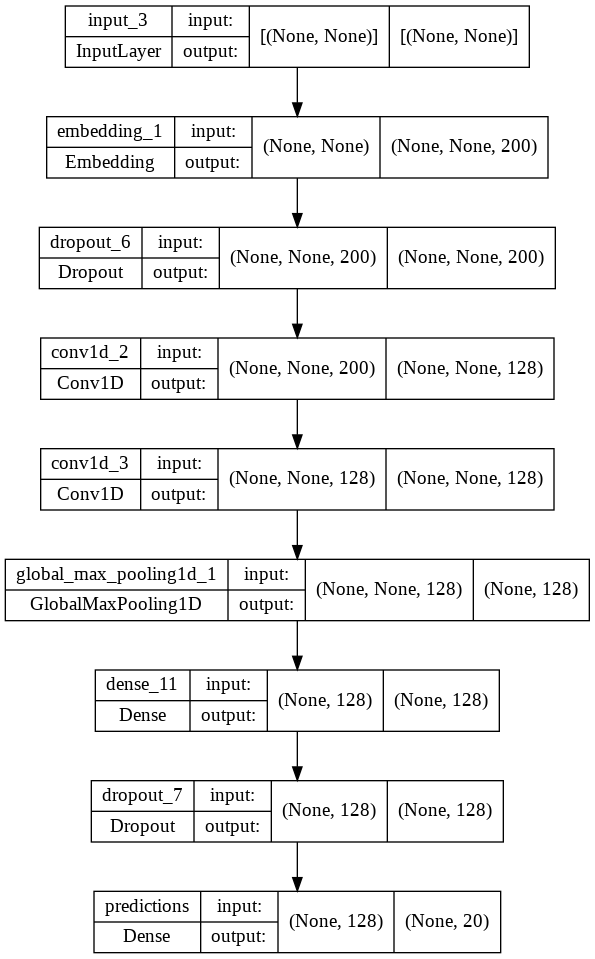

In [138]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

#### Model Training

In [140]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1,
    )
]

In [141]:
epochs = 50
batch_size=64
# Fit the model using the train and test datasets.
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history2=model.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=epochs,batch_size=batch_size,callbacks=callbacks)

Epoch 1/50
119/119 [==============================] - 29s 236ms/step - loss: 2.9779 - accuracy: 0.0619 - val_loss: 2.9218 - val_accuracy: 0.0964
Epoch 2/50
119/119 [==============================] - 29s 242ms/step - loss: 2.6989 - accuracy: 0.1115 - val_loss: 2.4236 - val_accuracy: 0.1650
Epoch 3/50
119/119 [==============================] - 28s 234ms/step - loss: 2.3332 - accuracy: 0.1822 - val_loss: 2.0952 - val_accuracy: 0.2697
Epoch 4/50
119/119 [==============================] - 28s 232ms/step - loss: 1.9479 - accuracy: 0.3047 - val_loss: 1.6923 - val_accuracy: 0.4317
Epoch 5/50
119/119 [==============================] - 28s 233ms/step - loss: 1.4455 - accuracy: 0.4745 - val_loss: 1.2651 - val_accuracy: 0.5964
Epoch 6/50
119/119 [==============================] - 29s 244ms/step - loss: 0.9894 - accuracy: 0.6487 - val_loss: 0.9694 - val_accuracy: 0.6987
Epoch 7/50
119/119 [==============================] - 29s 244ms/step - loss: 0.6779 - accuracy: 0.7654 - val_loss: 0.9358 - val_ac

#### Exhibit Accuracy and Validation Loss of CNN Model

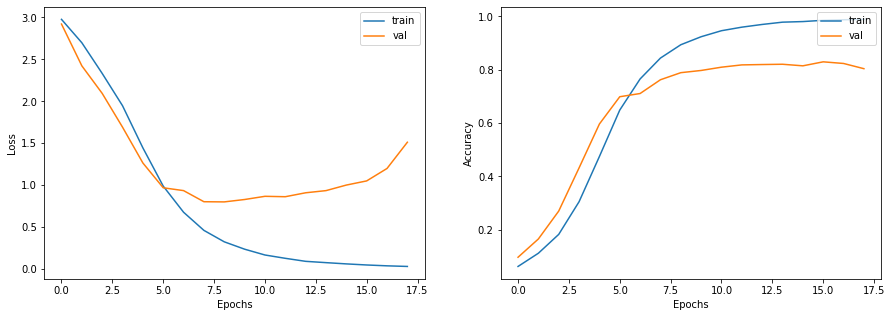

In [142]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history2.history["loss"])
ax1.plot(history2.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(history2.history["accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

#### Performance of CNN Model on Test Set

In [143]:
_, test_accuracy = model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 70.81%


In [144]:
cnn_pred = model.predict(x_test)
cnn_pred = pd.DataFrame(cnn_pred).apply(lambda x: x.argmax(), axis=1).values

In [145]:
macro_averaged_precision = precision_score(y_test, cnn_pred, average = 'macro')
print('Test macro averaged precision score:', macro_averaged_precision)

recall = recall_score(y_test, cnn_pred, average = 'macro')
print('Test recall score:', recall)

macro_averaged_f1 = f1_score(y_test, cnn_pred, average = 'macro')
print('Test macro averaged f1 score:', macro_averaged_f1)

Test macro averaged precision score: 0.7421373094915842
Test recall score: 0.6991779671162309
Test macro averaged f1 score: 0.7025539720329415


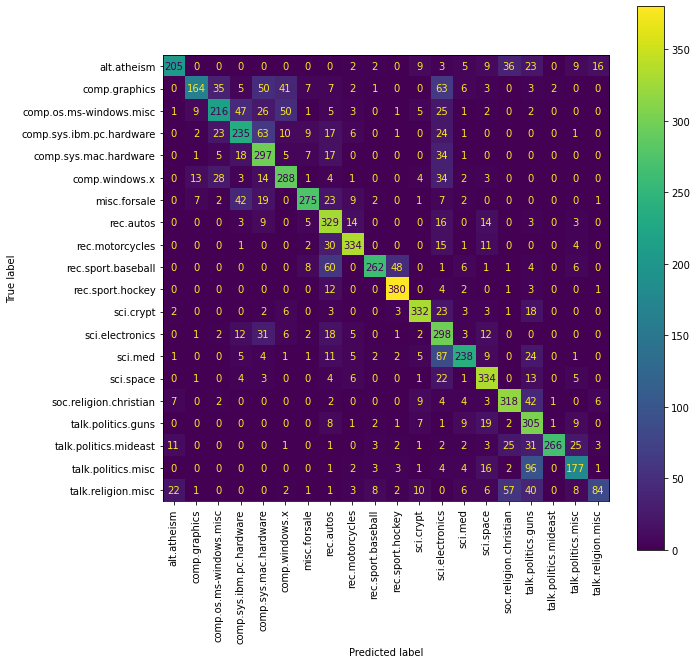

In [146]:
cm = confusion_matrix(y_test, cnn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=names)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax)

plt.show()

# Convert to vectors using word2vec

In [201]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
import tensorflow as tf
from tensorflow import keras
from keras import initializers
%matplotlib inline
from sklearn.model_selection import StratifiedShuffleSplit

# Creating Training,Validation and Testing Variables/Data

In [147]:
#Shuffling Data for Splitting Randomly
seed=1337
rng = np.random.RandomState(seed)
rng.shuffle(df_train.texts.values.tolist())
rng = np.random.RandomState(seed)
rng.shuffle(np.unique(df_train['folder name'].values.tolist()))


In [148]:
#Extracted the Required Data.
X = df_train['texts']
y = df_train['folder name']
X_test=df_test['texts']
y_test=df_test['folder name']


In [149]:
#Splitting the shuffled Training data into Training and Validation set
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
sss.get_n_splits(X, y)
print(sss)
for train_index, val_index in sss.split(X, y):
  print("train_index:", train_index, "val_index:", val_index)
  X_train, X_val = X[train_index], X[val_index]
  Y_train, Y_val = y[train_index], y[val_index]
  

StratifiedShuffleSplit(n_splits=2, random_state=0, test_size=0.2,
            train_size=None)
train_index: [4399 1738 8107 ...  830 7131 6141] val_index: [ 9746 10538  7549 ...  5743  9471  2987]
train_index: [ 7813  6432  7266 ... 11154  1357  6312] val_index: [11203  8338  5177 ...  9903   843  2575]


In [150]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# **Creating Text Vectorization from Training Dataset**

In [156]:
#Creating vectorizer and adapting to the training data to be use for all data,restriced to 20,000 vocabulary
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(X_train.values.tolist())
vectorizer.adapt(text_ds)

In [157]:
#testing vectorizer
vectorizer.get_vocabulary()[0:5]

['', '[UNK]', 'the', 'to', 'of']

In [158]:
#Creating word_index mapping to the vocabulary created from the vectorizer
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [159]:
#Testing word_index
test = ["cat", "sat", "mat"]
[word_index[w] for w in test]

[3707, 2712, 5903]

### Get Embeddings-Using GLOVE word2vec
GloVe is an unsupervised learning algorithm for obtaining vector representations for words

In [168]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-04-19 16:08:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-19 16:08:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-19 16:08:14--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

glove

# **Training the Embedding**

In [169]:
embeddings_index = {}
f = open('/content/glove.6B.100d.txt',encoding='utf8')# source of the downloaded glove files-use the 100d.txt
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [170]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0
embedding_matrix = np.random.random((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 17412 words (2588 misses)


# **PreTrained Embedding**

In [171]:
embedding_layer = Embedding(
num_tokens,
embedding_dim,
embeddings_initializer=keras.initializers.Constant(embedding_matrix),
trainable=False,)
embedding_layer

## **Preparing Data input for Models**

In [172]:
class_names=y.unique()
label_names=list(class_names)
label_index=(np.unique(label_names, return_inverse=True)[1])
label_code=(np.unique(y, return_inverse=True)[1])

In [173]:
print(X_train.shape, X_val.shape)
print(Y_train.shape, Y_val.shape)

(9051,) (2263,)
(9051,) (2263,)


In [174]:
x_train = vectorizer(np.array([[s] for s in X_train.values.tolist()])).numpy()
x_val = vectorizer(np.array([[s] for s in X_val.values.tolist()])).numpy()
x_test = vectorizer(np.array([[s] for s in X_test.values.tolist()])).numpy()
type(x_test)

numpy.ndarray

In [175]:
y_train=np.array(np.unique(Y_train, return_inverse=True)[1])
y_val=(np.unique(Y_val, return_inverse=True)[1])
y_test=(np.unique(y_test, return_inverse=True)[1])

# **1 dimensional CNN | Conv1D Maxpooling and GlobalMax Pooling Using PreTrained Embedding**

In [176]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(label_names), activation="softmax")(x)
model1 = keras.Model(int_sequences_input, preds)
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         2000200   
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_5 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 128)        0         
 1D)                                                       

# **Graphical represention of Model1**

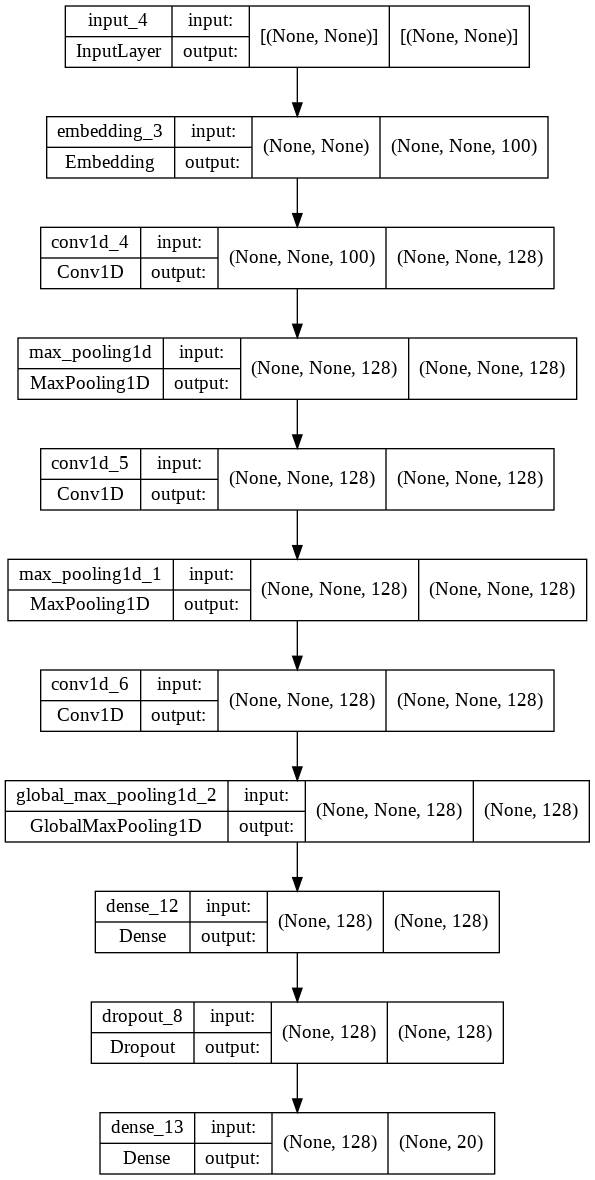

In [177]:
keras.utils.plot_model(model1, "multi_input_and_output_model.png", show_shapes=True)

# **Training Model1**

In [178]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 10 epochs"
        patience=10,
        verbose=1,
    )
]

In [179]:
epochs = 50
batch_size=64
model1.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)
cp=ModelCheckpoint('model_1.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history1=model1.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val),batch_size=batch_size,callbacks=callbacks)

Epoch 1/50
142/142 [==============================] - 20s 135ms/step - loss: 2.7241 - acc: 0.1281 - val_loss: 2.2183 - val_acc: 0.2258
Epoch 2/50
142/142 [==============================] - 19s 133ms/step - loss: 2.0451 - acc: 0.2955 - val_loss: 1.7125 - val_acc: 0.3959
Epoch 3/50
142/142 [==============================] - 19s 133ms/step - loss: 1.5134 - acc: 0.4656 - val_loss: 1.2301 - val_acc: 0.5550
Epoch 4/50
142/142 [==============================] - 19s 133ms/step - loss: 1.1430 - acc: 0.5974 - val_loss: 1.1580 - val_acc: 0.6032
Epoch 5/50
142/142 [==============================] - 19s 133ms/step - loss: 0.8844 - acc: 0.6861 - val_loss: 0.9358 - val_acc: 0.6849
Epoch 6/50
142/142 [==============================] - 19s 134ms/step - loss: 0.7124 - acc: 0.7589 - val_loss: 1.0569 - val_acc: 0.6801
Epoch 7/50
142/142 [==============================] - 19s 132ms/step - loss: 0.5482 - acc: 0.8107 - val_loss: 0.8395 - val_acc: 0.7499
Epoch 8/50
142/142 [==============================] - 1

# **Plotting the Accuracy and validation Loss for model1**

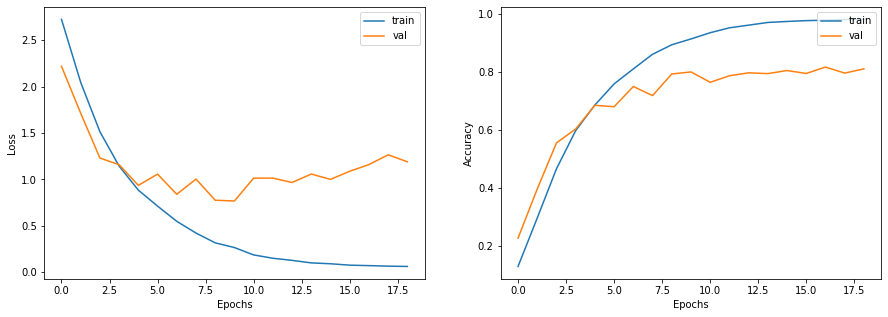

In [180]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history1.history["loss"])
ax1.plot(history1.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(history1.history["acc"])
ax2.plot(history1.history["val_acc"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

# **Testing Model1 with testing dataset**

In [181]:
_, test_accuracy = model1.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 71.82%


# **Predicting using unknow raw text-Model1**

In [182]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model1(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict([['Update and Re-fit a Model Call Description. update will update and (by default) re-fit a model']])

class_names[np.argmax(probabilities[0])]

'comp.os.ms-windows.misc'

## **1 dimensional CNN | Conv1D-without using Pre-trained Embedding**

In [183]:
import tensorflow as tf

In [184]:
from tensorflow.keras import layers

# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(num_tokens, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a multiclass unit output layer, and squash it with a softmax:
predictions = layers.Dense(len(label_names), activation="softmax", name="predictions")(x)

model2 = tf.keras.Model(inputs, predictions)

# Compile the model with multiclass crossentropy loss and an rmsprop optimizer.
model2.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
print("Simple Neural Network")
model2.summary()

Simple Neural Network
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 100)         2000200   
                                                                 
 dropout_9 (Dropout)         (None, None, 100)         0         
                                                                 
 conv1d_7 (Conv1D)           (None, None, 128)         89728     
                                                                 
 conv1d_8 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                     

# **Graphical representation of Model2**


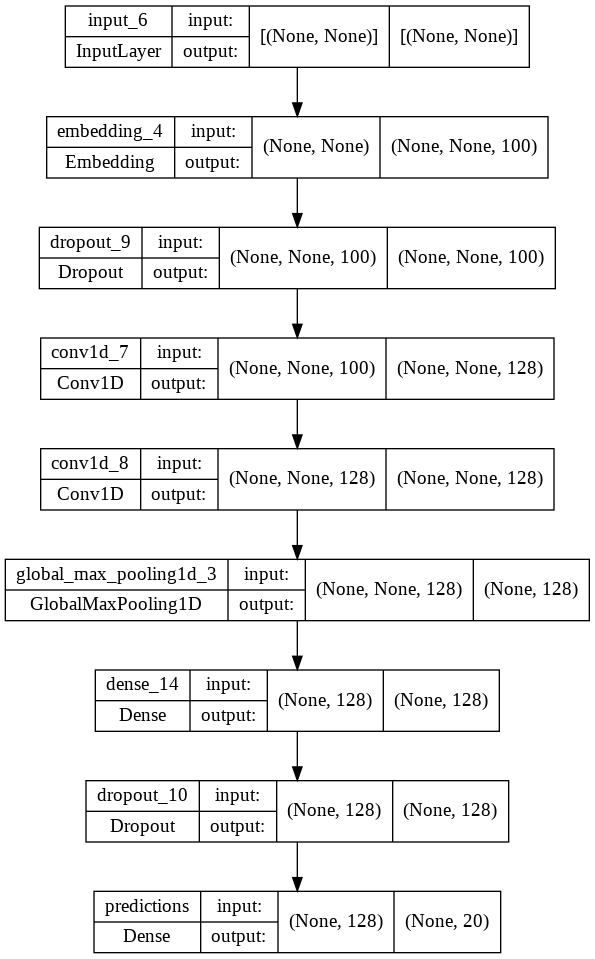

In [185]:
keras.utils.plot_model(model2, "multi_input_and_output_model.png", show_shapes=True)

# **Training of Model2**

In [186]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1,
    )
]

In [187]:
epochs = 50
batch_size=64
# Fit the model using the train and test datasets.
cp=ModelCheckpoint('model_1.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history2=model2.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=epochs,batch_size=batch_size,callbacks=callbacks)

Epoch 1/50
142/142 [==============================] - 22s 146ms/step - loss: 2.9763 - accuracy: 0.0647 - val_loss: 2.9083 - val_accuracy: 0.0871
Epoch 2/50
142/142 [==============================] - 23s 165ms/step - loss: 2.6343 - accuracy: 0.1214 - val_loss: 2.3850 - val_accuracy: 0.1586
Epoch 3/50
142/142 [==============================] - 20s 144ms/step - loss: 2.2951 - accuracy: 0.1759 - val_loss: 2.0847 - val_accuracy: 0.2673
Epoch 4/50
142/142 [==============================] - 20s 144ms/step - loss: 1.9851 - accuracy: 0.2743 - val_loss: 1.8454 - val_accuracy: 0.3685
Epoch 5/50
142/142 [==============================] - 20s 144ms/step - loss: 1.5547 - accuracy: 0.4377 - val_loss: 1.3780 - val_accuracy: 0.5524
Epoch 6/50
142/142 [==============================] - 20s 144ms/step - loss: 1.1311 - accuracy: 0.6065 - val_loss: 1.0302 - val_accuracy: 0.6783
Epoch 7/50
142/142 [==============================] - 20s 144ms/step - loss: 0.8094 - accuracy: 0.7215 - val_loss: 0.8687 - val_ac

# **Plotting Accuracy and validation loss of Model2**

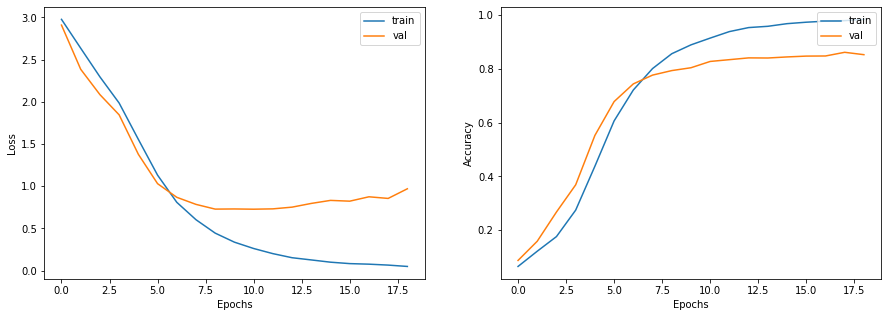

In [188]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history2.history["loss"])
ax1.plot(history2.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(history2.history["accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

# **Testing Model2 with Test dataset**

In [189]:
_, test_accuracy = model2.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 73.66%


# **Predicting unknown text with Model2**

In [190]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model2(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict(
    [['As a sanity check, if the embedding matrix has been generated properly. In the above, when I saw the first five entries of\nthe training set, the first entry was\n']]
)

class_names[np.argmax(probabilities[0])]
#df_train.texts[500]

'comp.graphics'

# **RNN-Bidirectional LSTM Model 50 Unit**

In [202]:
sequence_input = Input(shape=(200,), dtype='int64')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(50))(embedded_sequences)
preds = Dense(len(label_names), activation='softmax')(l_lstm)
model3 = Model(sequence_input, preds)
model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

print("Bidirectional LSTM")
model3.summary()

Bidirectional LSTM
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 200)]             0         
                                                                 
 embedding_3 (Embedding)     multiple                  2000200   
                                                                 
 bidirectional (Bidirectiona  (None, 100)              60400     
 l)                                                              
                                                                 
 dense_19 (Dense)            (None, 20)                2020      
                                                                 
Total params: 2,062,620
Trainable params: 62,420
Non-trainable params: 2,000,200
_________________________________________________________________


# **Graphical representation of model3**

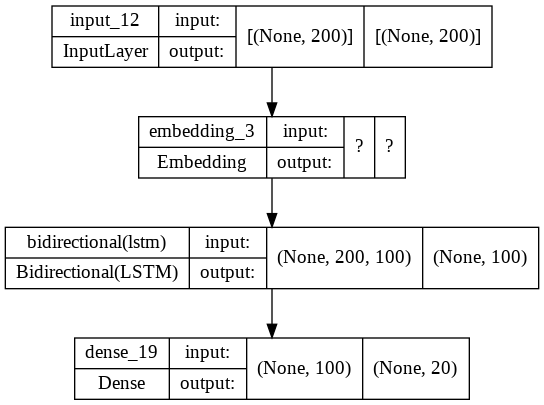

In [203]:
keras.utils.plot_model(model3, "multi_input_and_output_model.png", show_shapes=True)

# **Training Model3**

In [204]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1,
    )
]

In [205]:
epochs=30
batch_size=20
cp=ModelCheckpoint('model_1.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history3=model3.fit(x_train, y_train, validation_data=(x_val,y_val),epochs=epochs, batch_size=batch_size,callbacks=callbacks)

Epoch 1/30
453/453 [==============================] - 74s 152ms/step - loss: 2.4740 - acc: 0.2012 - val_loss: 1.9555 - val_acc: 0.3288
Epoch 2/30
453/453 [==============================] - 68s 149ms/step - loss: 1.7488 - acc: 0.4195 - val_loss: 1.5258 - val_acc: 0.4821
Epoch 3/30
453/453 [==============================] - 68s 151ms/step - loss: 1.2813 - acc: 0.5593 - val_loss: 1.1631 - val_acc: 0.6010
Epoch 4/30
453/453 [==============================] - 68s 150ms/step - loss: 1.0224 - acc: 0.6571 - val_loss: 1.0154 - val_acc: 0.6593
Epoch 5/30
453/453 [==============================] - 69s 152ms/step - loss: 0.8729 - acc: 0.7099 - val_loss: 0.9369 - val_acc: 0.6885
Epoch 6/30
453/453 [==============================] - 68s 151ms/step - loss: 0.7502 - acc: 0.7474 - val_loss: 0.8614 - val_acc: 0.7318
Epoch 7/30
453/453 [==============================] - 68s 151ms/step - loss: 0.6544 - acc: 0.7871 - val_loss: 0.7974 - val_acc: 0.7313
Epoch 8/30
453/453 [==============================] - 6

## **Plotting accuracy and loss of Model3**

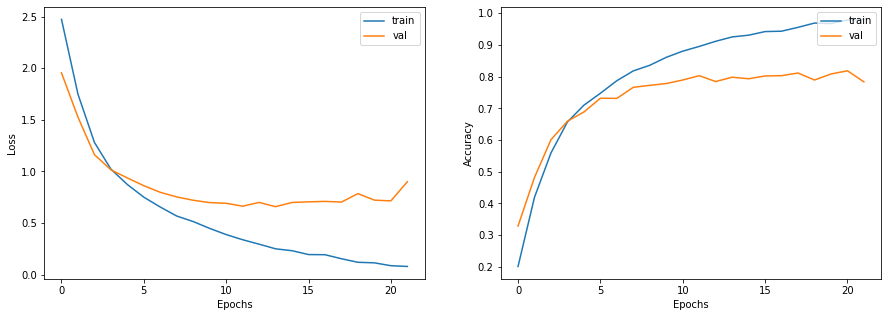

In [206]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history3.history["loss"])
ax1.plot(history3.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(history3.history["acc"])
ax2.plot(history3.history["val_acc"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

# **Testing Model3 on Testing data**

In [207]:
_, test_accuracy = model3.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 71.33%


# **Predicting with Model3**

In [208]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model3(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict(
    [['Jon playes cricket His favourite player is MS DhoniSometimes he loves to play football']]
)

class_names[np.argmax(probabilities[0])]

'alt.atheism'

# **1 dimensional CNN MODEL- Developed as a function**

In [209]:
def ConvNet1(embeddings, num_tokens, embedding_dim, label_code):
    
    embedding_layer = Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,)
    
    sequence_input = Input(shape=(None,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
    x = layers.MaxPooling1D(5)(x)
    x = layers.Conv1D(128, 5, activation="relu")(x)
    x = layers.MaxPooling1D(5)(x)
    x = layers.Conv1D(128, 5, activation="relu")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    preds = Dense(len(label_names), activation='softmax')(x)
    model = keras.Model(sequence_input, preds)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer="adam",
                  metrics=['acc'])
    model.summary()
    return model

In [210]:
model4 = ConvNet1(embedding_matrix, num_tokens,embedding_dim,label_code)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_7 (Embedding)     (None, None, 100)         2000200   
                                                                 
 conv1d_15 (Conv1D)          (None, None, 128)         64128     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_16 (Conv1D)          (None, None, 128)         82048     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, None, 128)        0         
 1D)                                                      

# **Graph of Model4**

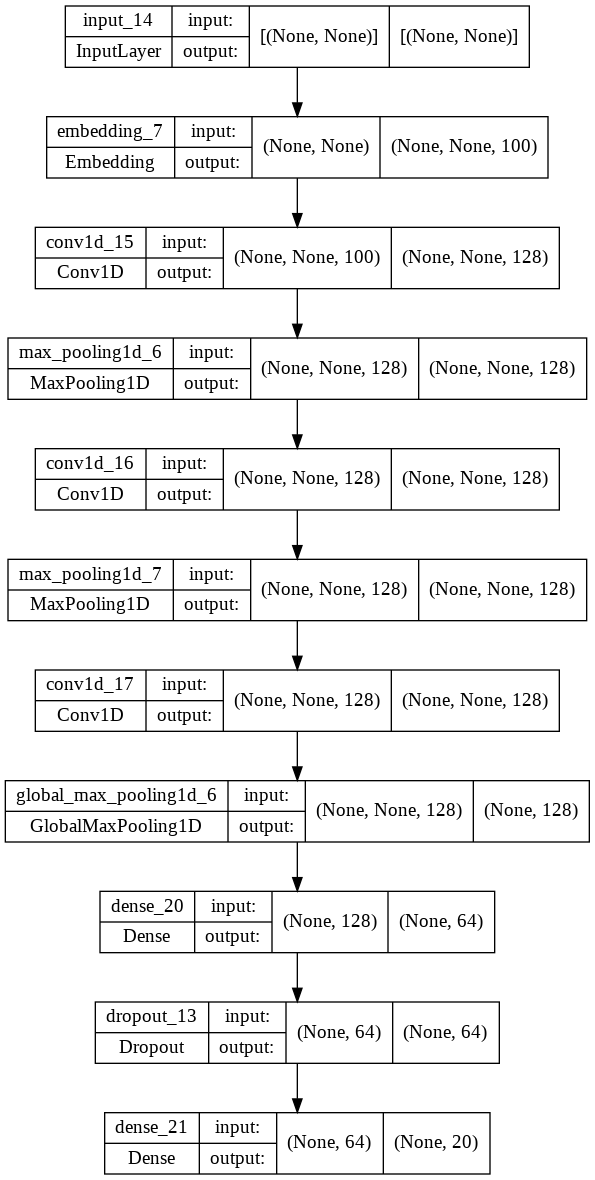

In [211]:
keras.utils.plot_model(model4, "multi_input_and_output_model.png", show_shapes=True)

# **Training of Model4**

In [212]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1,
    )
]

In [213]:
epochs=50
batch_size=64
cp=ModelCheckpoint('model_1.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

In [214]:
model4 = ConvNet1(embedding_matrix, num_tokens, embedding_dim,label_code)
history4 = model4.fit(x_train, y_train, epochs=epochs, shuffle=True,validation_data=(x_val,y_val), batch_size=batch_size,callbacks=callbacks)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_8 (Embedding)     (None, None, 100)         2000200   
                                                                 
 conv1d_18 (Conv1D)          (None, None, 128)         64128     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_19 (Conv1D)          (None, None, 128)         82048     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, None, 128)        0         
 1D)                                                      

## **Plotting accuracy and loss of Model4**

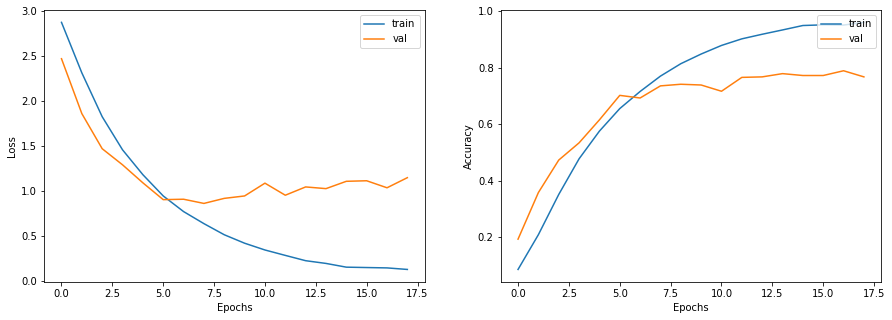

In [215]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history4.history["loss"])
ax1.plot(history4.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(history4.history["acc"])
ax2.plot(history4.history["val_acc"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

## **Testing Model4**

In [216]:
_, test_accuracy = model4.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 67.75%


# **Predicting with Model4**

In [200]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model4(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict(
    [["Jon playes cricket His favourite player is MS Dhoni Sometimes he loves to play football"]]
)

class_names[np.argmax(probabilities[0])]

'rec.sport.hockey'